In [218]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
batch_size = 32
classes = ('with_mask', 'no___mask')

## load and preprocessing images

In [219]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32,32)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])

In [220]:
# train dataset
train_dataset = torchvision.datasets.ImageFolder('../data/train/',transform=transform)
# data loader
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [221]:
# test dataset
test_dataset = torchvision.datasets.ImageFolder('../data/test/',transform=transform)
# data loader
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### visualize the images

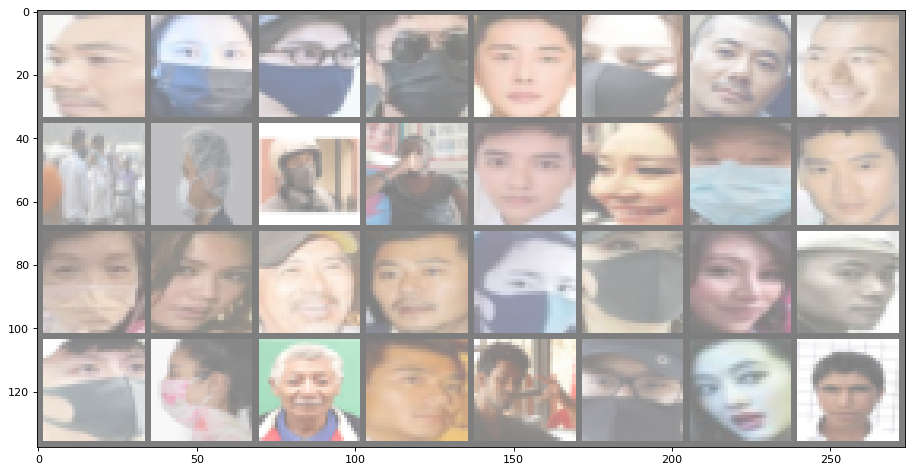

no___mask | with_mask | with_mask | with_mask | no___mask | with_mask | no___mask | no___mask | 
with_mask | with_mask | with_mask | no___mask | no___mask | no___mask | with_mask | no___mask | 
with_mask | no___mask | no___mask | no___mask | with_mask | with_mask | no___mask | no___mask | 
with_mask | with_mask | no___mask | no___mask | no___mask | with_mask | no___mask | no___mask


In [222]:
def imshow(img):
    figure(figsize=(14, 8), dpi=80)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# ploting the data
images, labels = next(iter(trainloader))

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' | '.join(f'\n{classes[labels[j-1]]}' if ((j-1)%8==0)&(j!=1) 
                 else f'{classes[labels[j-1]]}' for j in range(1, batch_size+1)))

### define cnn classifier

In [223]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = CNN()

#### define a loss function and optimizer

In [224]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### training and saving the network

In [225]:
MODEL_PATH = '../models/cnn/mask_recognition_21_08.pth'
loss_trend = []

for epoch in range(200):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if epoch %40 == 0:
        print(f' epoch:{epoch + 1}  loss: {running_loss}')
        torch.save(net.state_dict(), MODEL_PATH)
    loss_trend.append([epoch, running_loss])

print('Finished Training')

 epoch:1  loss: 89.39631628990173
 epoch:41  loss: 18.137095184996724
 epoch:81  loss: 9.726018003886566
 epoch:121  loss: 5.997079319669865
 epoch:161  loss: 0.33962484789662994
Finished Training


### test the network on test data

In [226]:
dataiter = iter(testloader)
images, labels = dataiter.next()

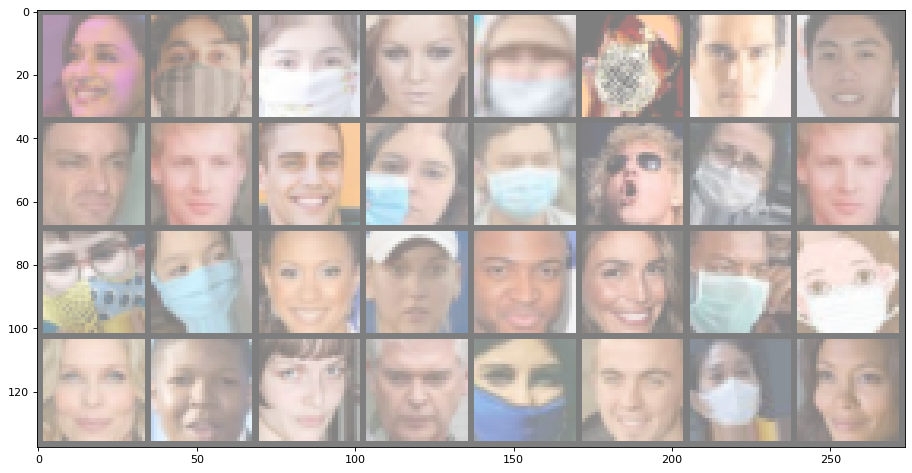

no___mask | with_mask | with_mask | no___mask | with_mask | with_mask | no___mask | no___mask | 
no___mask | no___mask | no___mask | with_mask | with_mask | no___mask | with_mask | no___mask | 
with_mask | with_mask | no___mask | no___mask | no___mask | no___mask | with_mask | with_mask | 
no___mask | no___mask | no___mask | no___mask | with_mask | no___mask | with_mask | no___mask


In [227]:
imshow(torchvision.utils.make_grid(images))
print(' | '.join(f'\n{classes[labels[j-1]]}' if ((j-1)%8==0)&(j!=1) 
                 else f'{classes[labels[j-1]]}' for j in range(1, batch_size+1)))

In [228]:
net = CNN()
net.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [229]:
outputs = net(images)

In [230]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  no___mask with_mask with_mask no___mask


In [231]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 95 %


In [232]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: with_mask is 93.4 %
Accuracy for class: no___mask is 97.7 %
